### Import Dependencies

In [108]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from tqdm import tqdm
from wordcloud import WordCloud
import contractions
import string
from collections import Counter
import emoji
from nltk.corpus import (
    opinion_lexicon,
    stopwords
)
from nltk.tokenize import word_tokenize
from itertools import islice
from scipy import stats

In [109]:
# Function to read data from source
def get_data(file_name: str) -> pd.DataFrame:
    """
    Load a JSON Lines (.jsonl) file into a pandas DataFrame.

    This function reads newline-delimited JSON (JSONL) files, where each line
    is a valid JSON object.

    Parameters
    ----------
    file_name : str
        Name of the JSONL file located inside the 'data/' directory.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the parsed JSONL data.
    """
    base_dir: Path = Path.cwd()
    file_path: Path = base_dir / "data" / file_name

    return pd.read_json(
        file_path,
        lines=True,
        convert_dates=False
    )

In [110]:
# Reading data
raw = get_data(r'message_dump_2.jsonl')

In [111]:
# creating a deep copy of raw data
df = raw.copy(deep=True)

In [112]:
# Preview of data
df.head(5)

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,reply_to_message_id,attachment_count,embed_count
0,704751211860983936,699975135905710208,698185293420822649,"Hi Friends,",1588096182552,NaN,NaN,[],None,0,0
1,704751384657920128,699975135905710208,698185293420822649,"Need a help , am able group/resample the data ...",1588096223750,NaN,NaN,[],None,0,0
2,704751414471294976,699975135905710208,698185293420822649,,1588096230858,NaN,NaN,[],None,1,0
3,704751722794319872,699975135905710208,698185293420822649,is there a way we have a interval based output...,1588096304368,NaN,NaN,[],None,0,0
4,704751946799513728,699975135905710208,698185293420822649,any function that can tweak or do i need to it...,1588096357775,NaN,NaN,[],None,0,0


In [113]:
# Shape of data
df.shape

(69790, 11)

In [114]:
# data dtypes of features
df.dtypes

message_id               int64
channel_id               int64
author_id               object
content                 object
created_at               int64
edited_at              float64
deleted_at             float64
mention_ids             object
reply_to_message_id     object
attachment_count         int64
embed_count              int64
dtype: object

### Null values

In [115]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,0
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,0
reply_to_message_id,0
attachment_count,0


In [116]:
# Replacing [] with -1 indicating no mentions in the message
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: -1 if x == [] else x
)

📌 Representation of No-Mention Messages in mention_ids Column

The mention_ids column was modified to explicitly represent messages that contain no user mentions. Entries that originally stored empty lists were replaced with the value −1 to indicate the absence of tagged users in a message.

In [117]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,0
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,0
reply_to_message_id,0
attachment_count,0


In [118]:
df.loc[df.content == "", 'content']

2         
12        
66        
69        
105       
        ..
69667     
69706     
69713     
69758     
69776     
Name: content, Length: 1617, dtype: object

In [119]:
df = df.assign(
    content = df.content.apply(lambda x: np.nan if x == "" else x)
)

📌 Empty Content Analysis

An analysis of the content column reveals the presence of 1,601 instances where the message content is an empty string. These entries are not recorded as null values but appear as blank text fields.

This indicates that certain messages exist in the dataset without any textual content while still being represented as valid records. The absence of text is therefore embedded within the data values themselves rather than being reflected through missing value indicators.

Overall, the content column includes a small but notable subset of messages with empty content, which may influence text-based analysis and summary statistics if not explicitly accounted for.

In [120]:
df.reply_to_message_id.value_counts()

reply_to_message_id
None                   64207
1307050131148898385       12
1389114038184575117        5
1413740169009299518        5
1326813346057687041        4
                       ...  
1466985613994754282        1
1466861908052414506        1
1466742369058820166        1
1466722027158245513        1
1466525179805962340        1
Name: count, Length: 4979, dtype: int64

In [121]:
df = df.assign(
    reply_to_msg_id = df.reply_to_message_id.apply(lambda x: -1 if x == 'None' else x)
).drop('reply_to_message_id', axis=1)

**📌 What is reply to message Id?**

The reply_to_message_id column contains the Discord message ID of the parent message that a given message is replying to. Discord generates these IDs using a system called snowflakes, which are very large integers designed to be globally unique. They look random, but they’re structured numbers that encode metadata such as the timestamp of when the message was created. When someone replies to a message, Discord stores the original message’s snowflake ID in the reply_to_message_id field, creating a link between the two messages. If you match this ID with the message_id column in your dataset, you can reconstruct conversation threads by joining messages to their parent messages. This mechanism is what allows you to trace reply chains, analyze interaction networks, and study how discussions evolve over time in the server.

**What does None Indicate**
'None' in the reply_to_message_id field indicates that the message is not a reply to any previous message and was posted as an independent message in the channel. In Discord data, this typically represents the start of a new conversational thread or a standalone contribution rather than a continuation of an existing reply chain. From an analytical perspective, messages with None values can be treated as root nodes in conversation structures

In [ ]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,1617
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,55347
attachment_count,0
embed_count,0


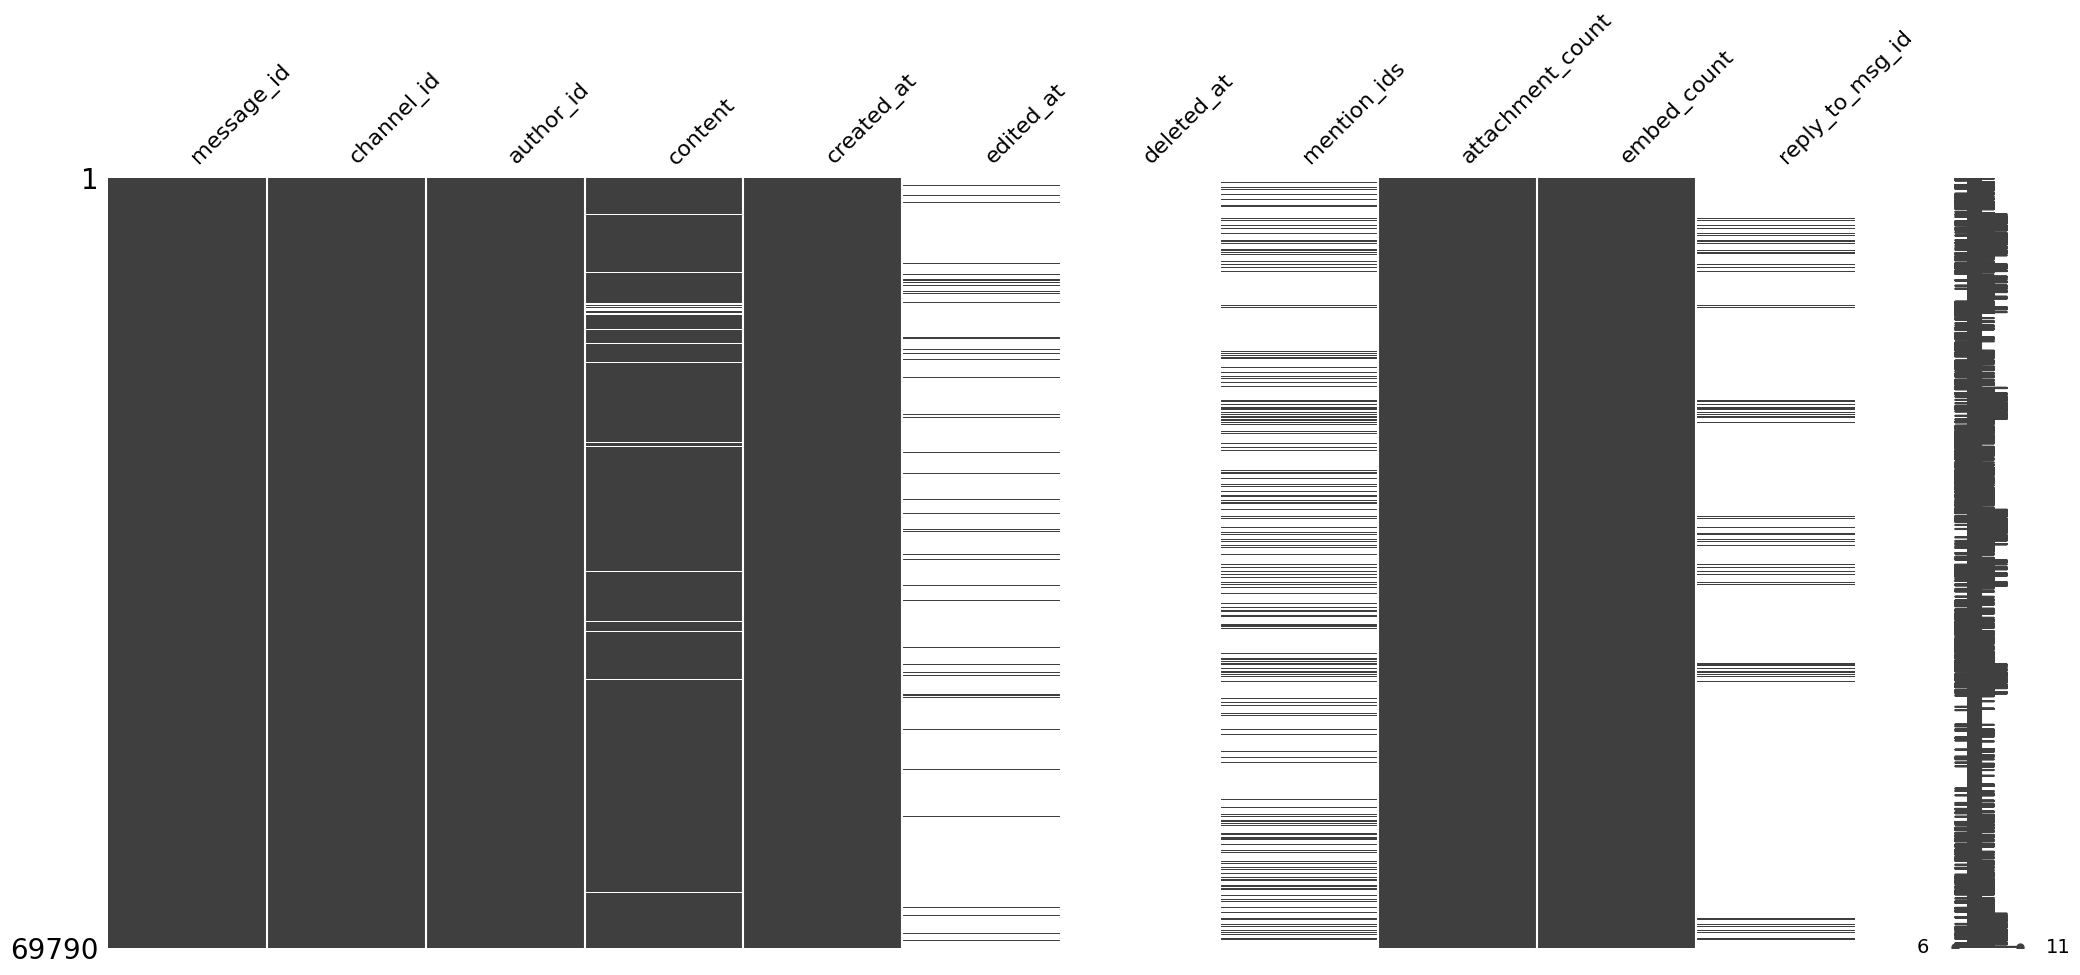

In [ ]:
# Matrix plot
msno.matrix(
    df = df,
    label_rotation=45,
    sparkline=True,
)
plt.show()

📌 Missing Value Distribution Across Columns

The dataset contains several columns that are fully populated, including message_id, channel_id, author_id, created_at, attachment_count, and embed_count. These fields show no missing values, indicating consistent availability of core message identifiers and metadata.

Missing values are present in multiple content-related and event-dependent columns. The content column has 1,617 missing entries, reflecting messages without textual content. A large number of missing values are observed in edited_at and deleted_at, with 66,228 and 69,679 null entries respectively.

The mention_ids column also exhibits substantial missingness, with 55,347 entries lacking values. In addition, reply_to_msg_id contains 64,207 missing entries, indicating that a majority of messages are not replies to other messages.

Overall, missing values are concentrated in optional or context-specific fields, while essential identifiers and structural attributes remain consistently populated across the dataset.

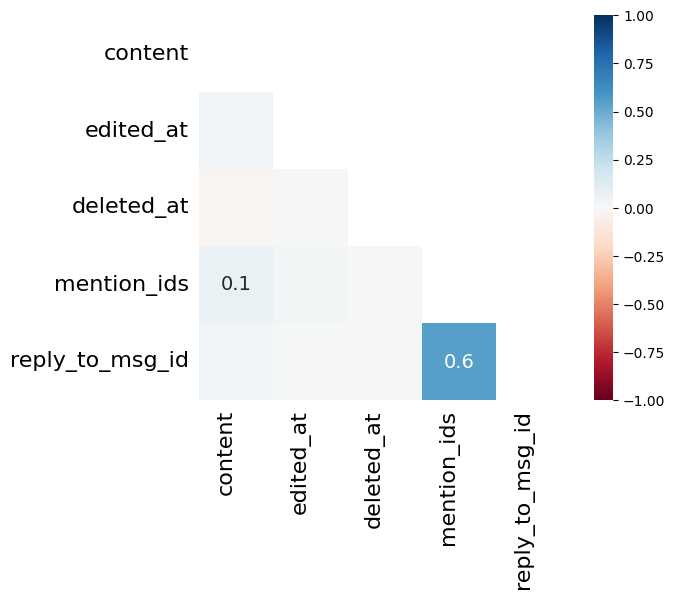

In [ ]:
# Heat map
msno.heatmap(
    df, 
    figsize=(6,5), 
    label_rotation=90, 
    labels=True
)
plt.show()

📌 Missing Value Relationship Heatmap – Observations

The heatmap shows the correlation between missing values across selected columns, including content, edited_at, deleted_at, mention_ids, and reply_to_msg_id. Overall, most relationships exhibit low correlation, indicating that missingness in these fields generally occurs independently.

A weak positive correlation of approximately 0.1 is observed between missing values in content and mention_ids. This suggests a slight overlap where messages without content are marginally more likely to lack mention information, though the association remains minimal.

The strongest relationship appears between missing values in mention_ids and reply_to_msg_id, with a correlation close to 0.6. This indicates a noticeable co-occurrence where messages without mentions are frequently also not replies to other messages.

Missingness in edited_at and deleted_at shows little to no correlation with other columns, suggesting that message edits and deletions are largely independent of content presence, mentions, or reply behavior.

Overall, the heatmap highlights one prominent association involving mention_ids and reply_to_msg_id, while other missing value relationships remain weak and scattered across the dataset.

In [ ]:
df.head(5)

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,attachment_count,embed_count,reply_to_msg_id
0,704751211860983936,699975135905710208,698185293420822649,"Hi Friends,",1588096182552,NaN,NaN,NaN,0,0,NaN
1,704751384657920128,699975135905710208,698185293420822649,"Need a help , am able group/resample the data ...",1588096223750,NaN,NaN,NaN,0,0,NaN
2,704751414471294976,699975135905710208,698185293420822649,NaN,1588096230858,NaN,NaN,NaN,1,0,NaN
3,704751722794319872,699975135905710208,698185293420822649,is there a way we have a interval based output...,1588096304368,NaN,NaN,NaN,0,0,NaN
4,704751946799513728,699975135905710208,698185293420822649,any function that can tweak or do i need to it...,1588096357775,NaN,NaN,NaN,0,0,NaN


In [ ]:
# type value counts
for col in df.columns:
    if col == 'created_at':
        continue
    print(df[col].apply(type).value_counts(dropna=False))
    print('='*50)

message_id
<class 'int'>    69790
Name: count, dtype: int64
channel_id
<class 'int'>    69790
Name: count, dtype: int64
author_id
<class 'str'>    69790
Name: count, dtype: int64
content
<class 'str'>      68173
<class 'float'>     1617
Name: count, dtype: int64
edited_at
<class 'float'>    69790
Name: count, dtype: int64
deleted_at
<class 'float'>    69790
Name: count, dtype: int64
mention_ids
<class 'float'>    55347
<class 'list'>     14443
Name: count, dtype: int64
attachment_count
<class 'int'>    69790
Name: count, dtype: int64
embed_count
<class 'int'>    69790
Name: count, dtype: int64
reply_to_msg_id
<class 'float'>    64207
<class 'str'>       5583
Name: count, dtype: int64


In [ ]:
df.loc[df.mention_ids.apply(type) == list, 'mention_ids']

7          [95605730538684416]
15        [635543257979420672]
21        [248596780789268481]
25        [483296676824481792]
26        [248596780789268481]
                 ...          
69753    [1168496774328102983]
69757     [304655299631906816]
69778     [767694543231385630]
69785    [1410737019855966440]
69786    [1420445590864662568]
Name: mention_ids, Length: 14443, dtype: object

The coexistence of float and list types within the same column introduces structural inconsistency in the dataset. This inconsistency affects uniform processing of the column, as operations expecting a single data type cannot be applied reliably across all records.

In [ ]:
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

In [ ]:
df.mention_ids.apply(type).value_counts()

mention_ids
<class 'float'>    55347
<class 'str'>      14443
Name: count, dtype: int64

In [ ]:
# Checking for duplicate instances
df.duplicated().sum()

np.int64(0)

📌 Duplicate values

There are no duplicates in the data which indicates that every row is unique.

In [ ]:
# Number of unique values in each feature
for col in df.columns:
    print(f'nunique values in {col}: {df[col].nunique()}')
    print('='*50)

nunique values in message_id: 69790
nunique values in channel_id: 12
nunique values in author_id: 8006
nunique values in content: 62098
nunique values in created_at: 69790
nunique values in edited_at: 3562
nunique values in deleted_at: 98
nunique values in mention_ids: 3422
nunique values in attachment_count: 8
nunique values in embed_count: 6
nunique values in reply_to_msg_id: 4978


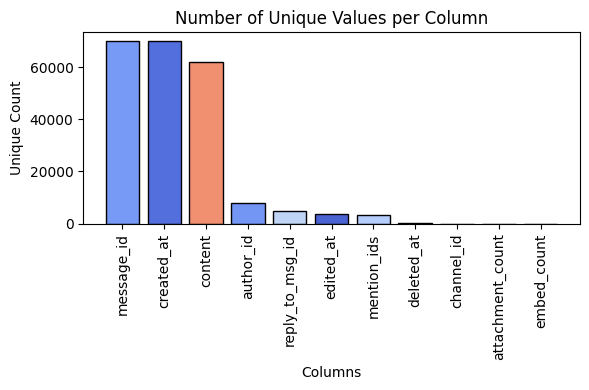

In [ ]:
nunique = df.nunique().sort_values(ascending=False)

colors = np.random.rand(len(nunique))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    nunique.index,
    nunique.values,
    edgecolor="black",
    linewidth=1,
    color = plt.cm.coolwarm(colors),
)

ax.set_title("Number of Unique Values per Column")
ax.set_xlabel("Columns")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

### author_id

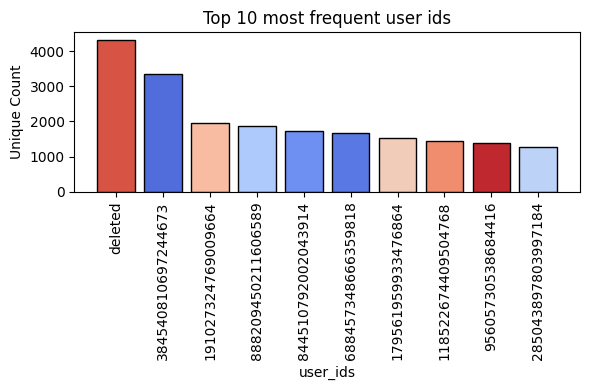

In [27]:
top_user_ids = df.author_id.value_counts().sort_values(ascending=False).nlargest(n=10)

colors = np.random.rand(len(top_user_ids))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_user_ids.index,
    top_user_ids.values,
    color = plt.cm.coolwarm(colors),
    edgecolor='black'
)

ax.set_title('Top 10 most frequent user ids')
ax.set_xlabel("user_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

In [28]:
top_user_ids

author_id
deleted               4317
384540810697244673    3355
191027324769009664    1959
888209450211606589    1858
844510792002043914    1732
688457348666359818    1660
179561959933476864    1541
118522674409504768    1436
95605730538684416     1374
285043897803997184    1276
Name: count, dtype: int64

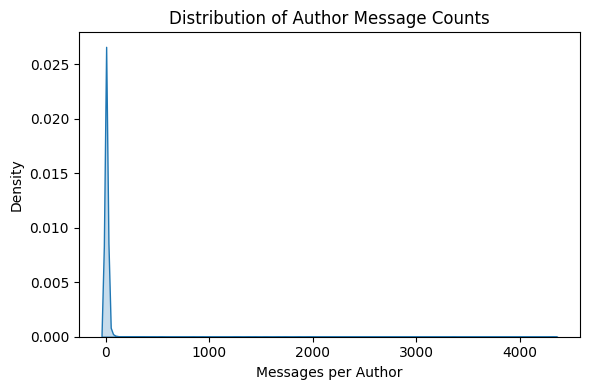

In [29]:
# Data
x = df['author_id'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.kdeplot(x=x, fill=True)

plt.title("Distribution of Author Message Counts")
plt.xlabel("Messages per Author")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

📌 Message Distribution by Author IDs

The distribution of messages by author_id shows that message activity is concentrated among a small group of users. The highest message count is associated with the identifier labeled “deleted,” which accounts for 4,317 messages, indicating a notable portion of messages originating from accounts that are no longer active or identifiable.

Several individual user IDs contribute substantial message volumes. The most active identifiable user recorded 3,355 messages, followed by other high-activity users with counts ranging between approximately 1,200 and 2,000 messages.

After the top contributors, message counts decrease gradually across remaining users. This pattern indicates that a limited number of authors generate a disproportionately large share of total messages, while the rest of the user base contributes smaller volumes of activity.

Overall, the author-level distribution reflects uneven participation, with message generation concentrated among a subset of highly active users.


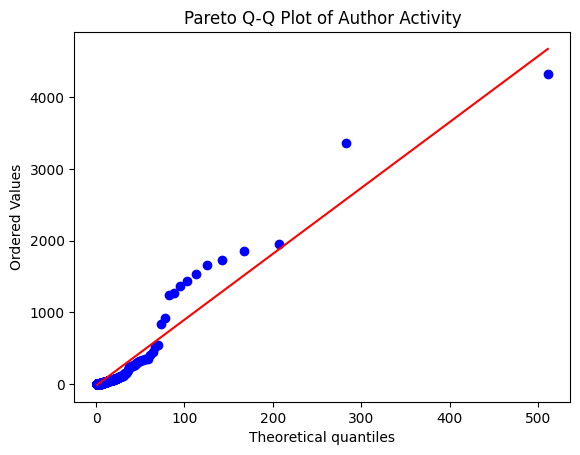

In [30]:
# Plotting QQ-plot to check for pareto distribution
stats.probplot(x, dist='pareto', plot=plt, sparams=1.5)
plt.title("Pareto Q-Q Plot of Author Activity")
plt.show()

📌 Pareto Distribution Pattern in Author Activity

The Q Q plot comparing author activity against a theoretical Pareto distribution shows a strong alignment between the observed data and the reference line, particularly across the central range of values. Most data points follow the general upward trend of the Pareto model, indicating a heavy tailed distribution in message activity.

A small number of points deviate noticeably at the upper end of the plot, representing highly active authors with message counts significantly larger than the majority. These extreme values form a visible tail and reinforce the presence of disproportionate contribution from a few users.

Overall, the visual pattern in the Q Q plot is consistent with a Pareto like distribution, where a limited subset of authors accounts for a large share of total message activity while the majority contribute relatively small volumes.


In [31]:
df.loc[df.author_id.eq(179561959933476864)]

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,attachment_count,embed_count,reply_to_msg_id


### channel_id

In [32]:
df.dtypes

message_id            int64
channel_id            int64
author_id            object
content              object
created_at            int64
edited_at           float64
deleted_at          float64
mention_ids          object
attachment_count      int64
embed_count           int64
reply_to_msg_id      object
dtype: object

In [33]:
# Convert ids into strings for better analysis

df = df.assign(
    message_id = df.message_id.astype(str),
    edited_at = df.edited_at.astype(str),
    created_at  = df.created_at.astype(str),
    deleted_at = df.deleted_at.astype(str),
    channel_id = df.channel_id.astype(str)
)

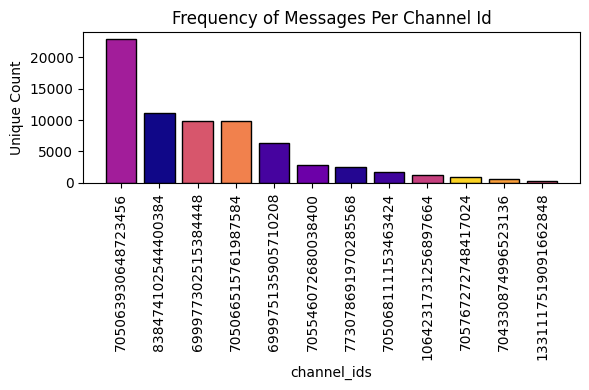

In [34]:
top_channel_id = df.channel_id.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(top_channel_id))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_channel_id.index,
    top_channel_id.values,
    color = plt.cm.plasma(colors),
    edgecolor='black'
)

ax.set_title('Frequency of Messages Per Channel Id')
ax.set_xlabel("channel_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

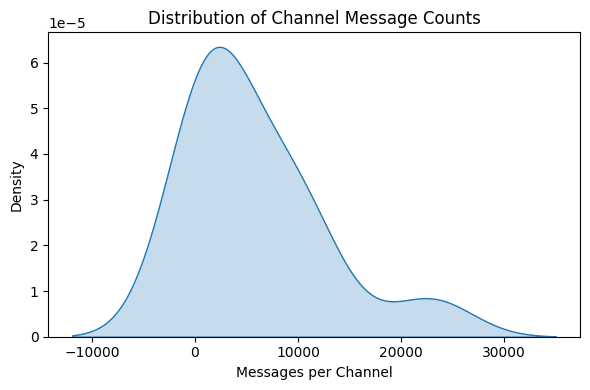

In [35]:
# Data
x = df['channel_id'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.kdeplot(x=x, fill=True)

plt.title("Distribution of Channel Message Counts")
plt.xlabel("Messages per Channel")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

📌 Message Frequency Distribution Across Channel IDs

The bar chart shows a highly skewed distribution of messages across channel IDs. One channel dominates the dataset with a significantly higher message count compared to all others, indicating a primary hub of activity.

A small group of channels forms a second tier with moderately high message volumes, but their counts are notably lower than the most active channel. These channels still contribute a substantial portion of overall messages relative to the rest.

Beyond the top few channels, message frequency drops sharply. Most remaining channels exhibit relatively low message counts, forming a long tail of low-activity channels.

Overall, message activity is concentrated within a limited number of channels, while the majority of channels show sparse participation and lower engagement levels.

### attachment_count

In [36]:
df.attachment_count.value_counts()

attachment_count
0    66777
1     2844
2      118
3       24
4       16
6        5
5        4
7        2
Name: count, dtype: int64

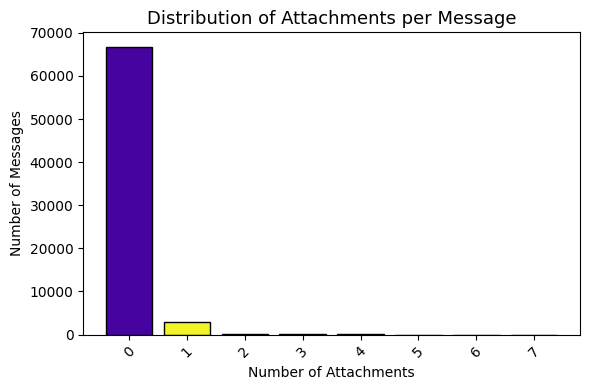

In [37]:
attachment_count = df.attachment_count.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(attachment_count))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    attachment_count.index,
    attachment_count.values,
    color=plt.cm.plasma(colors),
    edgecolor="black"
)

ax.set_title("Distribution of Attachments per Message", fontsize=13)
ax.set_xlabel("Number of Attachments")
ax.set_ylabel("Number of Messages")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

📌 Attachment Count Distribution in Messages

The majority of messages contain no attachments, with 66,069 messages having an attachment_count of zero. This indicates that attachments are not commonly used in most message.

Messages with a single attachment form a much smaller group, totaling 2,822 instances. As the number of attachments increases, the frequency of messages drops sharply. Only 117 messages contain two attachments, and counts beyond this point decrease to a few dozen or single-digit occurrences.

Messages with three or more attachments are rare, with the highest observed attachment count being seven, appearing in only two messages. Overall, the distribution is heavily skewed toward messages without attachments, with multi-attachment messages occurring infrequently across the dataset.

In [38]:
df.dtypes

message_id          object
channel_id          object
author_id           object
content             object
created_at          object
edited_at           object
deleted_at          object
mention_ids         object
attachment_count     int64
embed_count          int64
reply_to_msg_id     object
dtype: object

## embed_count

In [39]:
df.embed_count.value_counts()

embed_count
0    67435
1     2224
2       98
3       18
5        9
4        6
Name: count, dtype: int64

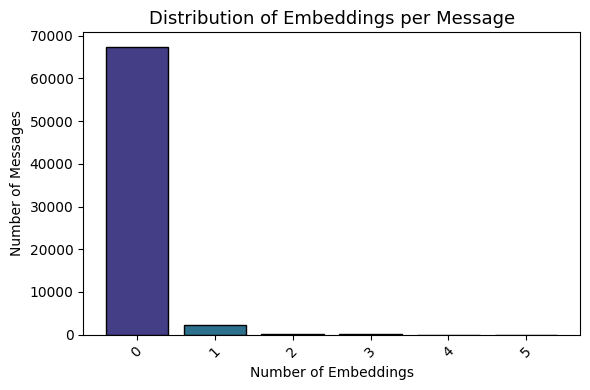

In [40]:
emb_count = df.embed_count.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(emb_count))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    emb_count.index,
    emb_count.values,
    color=plt.cm.viridis(colors),
    edgecolor="black"
)

ax.set_title("Distribution of Embeddings per Message", fontsize=13)
ax.set_xlabel("Number of Embeddings")
ax.set_ylabel("Number of Messages")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

📌 Embed Count Distribution in Messages

The embed_count distribution shows that the majority of messages do not contain any embedded content. A total of 67,435 messages have an embed_count of zero, indicating that embeds are rarely used in most communications.

Messages containing a single embed are far less common, with 2,224 occurrences. As the number of embeds increases, the frequency of messages declines sharply. Only 98 messages contain two embeds, and counts beyond this point drop to fewer than 20 instances.

Messages with four or five embeds are extremely rare, appearing only a handful of times in the dataset. Overall, the distribution is heavily skewed toward messages without embeds, with multi-embed messages representing a very small fraction of total activity.

### contents

Text cleaning

In [41]:
df.head(5)

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,attachment_count,embed_count,reply_to_msg_id
0,704751211860983936,699975135905710208,698185293420822649,"Hi Friends,",1588096182552,nan,nan,NaN,0,0,NaN
1,704751384657920128,699975135905710208,698185293420822649,"Need a help , am able group/resample the data ...",1588096223750,nan,nan,NaN,0,0,NaN
2,704751414471294976,699975135905710208,698185293420822649,NaN,1588096230858,nan,nan,NaN,1,0,NaN
3,704751722794319872,699975135905710208,698185293420822649,is there a way we have a interval based output...,1588096304368,nan,nan,NaN,0,0,NaN
4,704751946799513728,699975135905710208,698185293420822649,any function that can tweak or do i need to it...,1588096357775,nan,nan,NaN,0,0,NaN


In [42]:
# Text cleaning

df = df.assign(
    content=lambda x: (
        x["content"]
        .str.lower()
        .str.replace(r"<[^>]+>", "<USER>", regex=True)
        .str.replace("@everyone", "<EVERYONE>", regex=False)
        .str.replace("\n", " ", regex=False)
    )
)

In [43]:
# Replacing http links with special token
df = df.assign(
    content=lambda x: x.content.str.replace(
        r"https?://\S+|www\.\S+",
        "<LINK>",
        regex=True
    )
)

In [44]:
# Expanding Contractions
df = df.assign(
    content = lambda x: (
        x.content.fillna("").apply(contractions.fix)
    )
)

df.loc[df["content"].eq(""), "content"] = np.nan

In [45]:
# Replacing emoji with special token <emoji>
df = df.assign(
    content=lambda x: x.content.apply(
        lambda t: emoji.replace_emoji(t, replace="<EMOJI>") if pd.notna(t) else t
    )
)

In [46]:
# Removing Punctuation and fix extra spaces

df = df.assign(
    content=lambda x: (
        x.content
        .str.replace(r"[^\w\s.!?'<>]", "", regex=True)  # selective punctuation
        .str.replace(r"\s+", " ", regex=True)           # collapse spaces
        .str.strip()                                    # trim ends
    )
)

In [47]:
# Dropping null values in content
df = df.dropna(subset=["content"])

In [48]:
# Dropping instances with less than two characters and no characters
df = df[(df['content'].str.len() >= 2) & (df['content'] != (""))]

In [49]:
STOP_WORDS  = set(stopwords.words('english'))

In [50]:
df = df.assign(
    content_no_stopwords=lambda x: x.content.apply(
        lambda t: " ".join(
            w for w in t.split() if w not in STOP_WORDS
        )
    )
)

In [51]:
corpus = df.content_no_stopwords.to_list()

counter = Counter()

for sentence in corpus:
    counter.update(sentence.split())

In [52]:
for i in islice(counter, 10):
    print(i)

hi
friends
need
help
able
groupresample
data
weekly
per
image


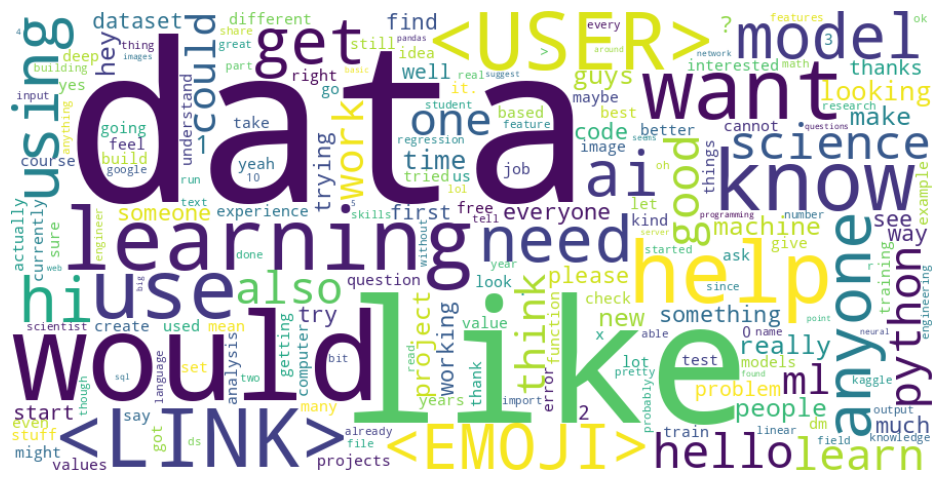

In [53]:
wc = WordCloud(
    width=900,
    height=450,
    background_color="white"
)

wc.generate_from_frequencies(counter)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [54]:
# Creating new dataframe for detailed text analysis
content_df = pd.DataFrame(df[(df['content_no_stopwords'].str.len() >= 2) & (df['content_no_stopwords'] != (""))]['content_no_stopwords'])

In [55]:
pos = set(opinion_lexicon.positive())
neg = set(opinion_lexicon.negative())

content_df = content_df.assign(
    pos_words_count=lambda x: x.content_no_stopwords.apply(
        lambda t: sum(w in pos for w in word_tokenize(t))
    ),
    neg_words_count=lambda x: x.content_no_stopwords.apply(
        lambda t: sum(w in neg for w in word_tokenize(t))
    )
)

In [56]:
content_df.sort_values(by='neg_words_count', ascending=False)

,content_no_stopwords,pos_words_count,neg_words_count
19628,hi anyone help resolve error. trained agent us...,2,19
62552,ever thought afterlife? mean life death intere...,6,18
62591,ever thought afterlife? mean life death intere...,6,18
44289,arctic xero uses ai develop lots new technolog...,5,17
6254,hi! great question common pain point facenet p...,21,15
...,...,...,...
69786,yes company already algo trading. you?,0,0
69787,help first 10 people interested start earning ...,0,0
69788,help first 10 people interested start earning ...,0,0
13,guys find values comedy it?,0,0


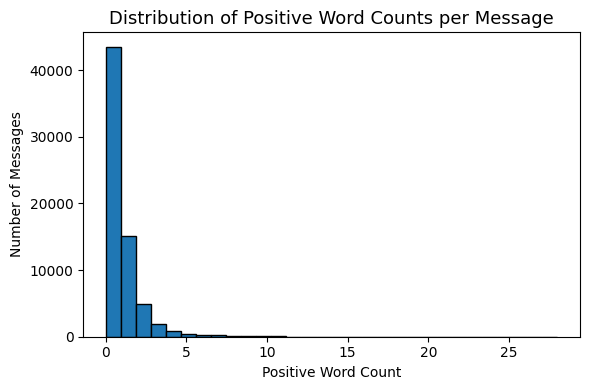

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(
    content_df["pos_words_count"],
    bins=30,
    edgecolor="black"
)

ax.set_title("Distribution of Positive Word Counts per Message", fontsize=13)
ax.set_xlabel("Positive Word Count")
ax.set_ylabel("Number of Messages")

plt.tight_layout()
plt.show()


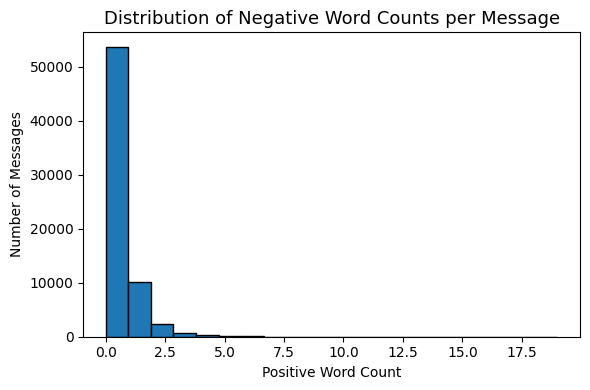

In [58]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(
    content_df["neg_words_count"],
    bins=20,
    edgecolor="black"
)

ax.set_title("Distribution of Negative Word Counts per Message", fontsize=13)
ax.set_xlabel("Positive Word Count")
ax.set_ylabel("Number of Messages")

plt.tight_layout()
plt.show()

In [59]:
# Making the data type of ids consistent
content_df = content_df.assign(
    char_count=lambda x: x["content_no_stopwords"].str.len(),
    word_count=lambda x: x["content_no_stopwords"].str.split().str.len(),
    emoji_count = lambda x: x["content_no_stopwords"].str.count('<EMOJI>'),
    user_ping_count = lambda x: x["content_no_stopwords"].str.count('<USER>'),
    link_count = lambda x: x["content_no_stopwords"].str.count('<LINK>')
)

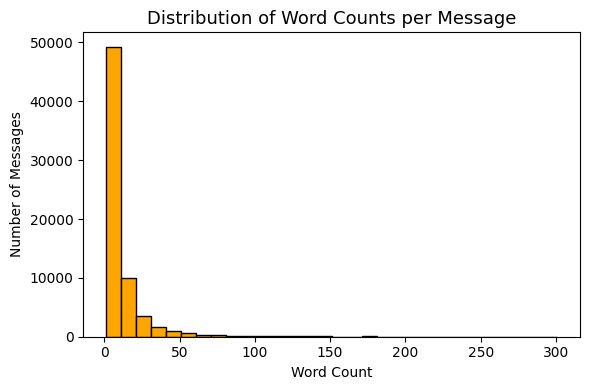

In [60]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(
    content_df["word_count"],
    bins=30,
    edgecolor="black",
    color='orange'
)

ax.set_title("Distribution of Word Counts per Message", fontsize=13)
ax.set_xlabel("Word Count")
ax.set_ylabel("Number of Messages")

plt.tight_layout()
plt.show()

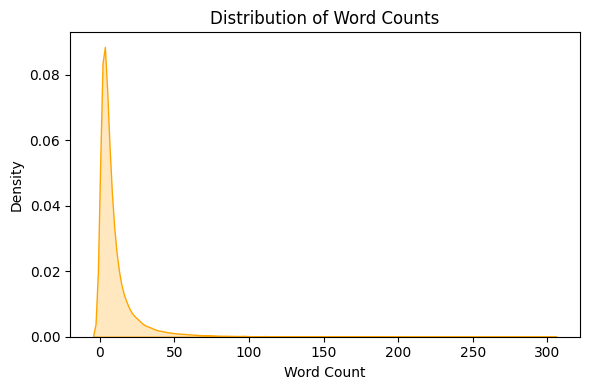

In [61]:
# Plot
plt.figure(figsize=(6, 4))
sns.kdeplot(x=content_df.word_count, fill=True, color='orange')

plt.title("Distribution of Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

📌 Distribution of Word Counts in Messages

The word count distribution is highly concentrated at low values, with the peak density occurring among messages containing only a few words. Most messages fall within this short length range, forming a sharp cluster near the lower end of the scale.

As word counts increase, the density decreases rapidly and extends into a long right tail. Only a small number of messages contain high word counts, and these appear infrequently compared to the dominant group of short messages.

Overall, the distribution is strongly right skewed, indicating that brief messages are the primary form of communication, while longer messages represent rare extreme values.

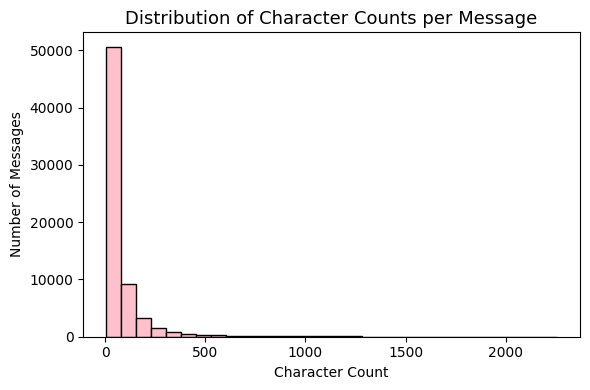

In [62]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(
    content_df["char_count"],
    bins=30,
    edgecolor="black",
    color='pink'
)

ax.set_title("Distribution of Character Counts per Message", fontsize=13)
ax.set_xlabel("Character Count")
ax.set_ylabel("Number of Messages")

plt.tight_layout()
plt.show()

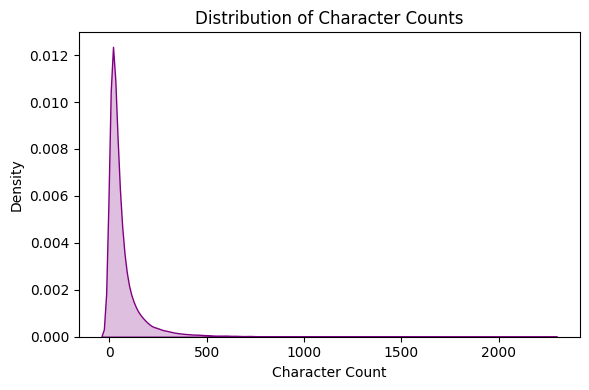

In [63]:
plt.figure(figsize=(6, 4))

sns.kdeplot(x=content_df['char_count'], fill=True, color='purple')

plt.title("Distribution of Character Counts")
plt.xlabel("Character Count")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

📌 Distribution of Character Counts in Messages

The distribution of character counts shows that most messages are concentrated at very low character values. The density peaks sharply near the lower end of the range, indicating that short messages make up the majority of the dataset.

As character counts increase, the density declines quickly and extends into a long right tail. Only a small portion of messages contain very high character counts, creating extreme values that are far less frequent than the central cluster.

Overall, the pattern demonstrates a strongly right skewed distribution in which short messages dominate, while very long messages appear infrequently and form a heavy tailed extension of the distribution.

In [64]:
stats = ['min', 'max', 'mean']

In [65]:
for c in content_df.columns:
    if content_df[c].dtype != 'object':
        print(f"\nStats for {c}:")
        for st in stats:
            print(f"  {st}: {getattr(content_df[c], st)()}")


Stats for pos_words_count:
  min: 0
  max: 28
  mean: 0.6511796679453191

Stats for neg_words_count:
  min: 0
  max: 19
  mean: 0.30301100430989797

Stats for char_count:
  min: 2
  max: 2259
  mean: 74.73422295946327

Stats for word_count:
  min: 1
  max: 301
  mean: 10.560879159940164

Stats for emoji_count:
  min: 0
  max: 21
  mean: 0.06199736370503118

Stats for user_ping_count:
  min: 0
  max: 37
  mean: 0.05337756779573157

Stats for link_count:
  min: 0
  max: 17
  mean: 0.05386631911017639


📌 Descriptive Statistics of Message Content Features

The computed statistics across multiple text-derived features show that most messages are short and contain limited auxiliary elements. Both positive and negative word counts have minimum values of zero, with maximum values of 28 and 19 respectively. Their mean values remain below one, indicating that sentiment-associated words appear infrequently in typical messages.

Character and word count distributions highlight the variability in message length. Character counts range from 1-2 to 2,259 with an average of approximately 74 characters, while word counts range from 0 to 301 with an average of about 10 words. This suggests that most messages are relatively brief, with a small number of unusually long entries extending the upper range.

Emoji usage is minimal across the dataset. Emoji counts vary from 0 to 21, with a very low average close to zero, indicating that emojis are rarely included in messages. A similar pattern appears in user ping and link counts, both of which have maximum values of 37 and 17 respectively but maintain mean values near zero.

Overall, these statistics indicate that the majority of messages are concise and text-focused, with sentiment words, emojis, mentions, and links appearing only occasionally.